In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.misc import imread, imresize
from keras.preprocessing.image import img_to_array, load_img

import cv2

# Visualizations will be shown inline
%matplotlib inline

In [3]:
data_frame = pd.read_csv("data/driving_log.csv", usecols=[0,1,2,3])

data_frame.describe(include="all")

,center,left,right,steering
count,8036,8036,8036,8036.000000
unique,8036,8036,8036,NaN
top,IMG/center_2016_12_01_13_41_26_018.jpg,IMG/left_2016_12_01_13_35_38_001.jpg,IMG/right_2016_12_01_13_42_17_737.jpg,NaN
freq,1,1,1,NaN
mean,NaN,NaN,NaN,0.004070
std,NaN,NaN,NaN,0.128840
min,NaN,NaN,NaN,-0.942695
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b021048>]], dtype=object)

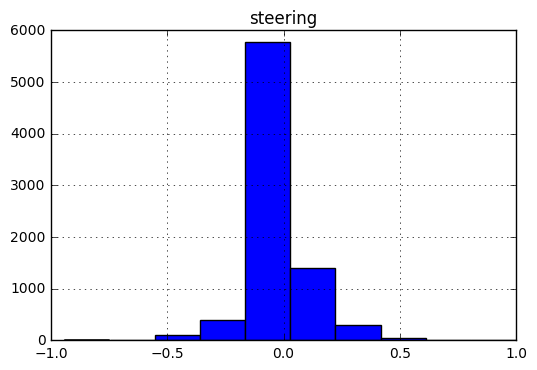

In [4]:
data_frame.hist(column="steering")

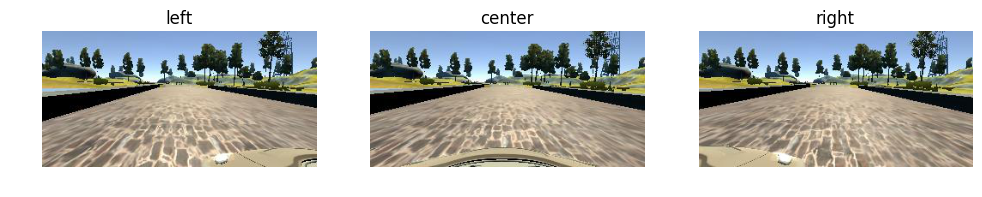

In [7]:
from keras.preprocessing.image import img_to_array, load_img

plt.rcParams['figure.figsize'] = (12, 6)

i = 0
for camera in ["left", "center", "right"]:
    image = load_img("data/"+data_frame.iloc[0][camera].strip())
    image = img_to_array(image).astype(np.uint8)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera)
    i += 1

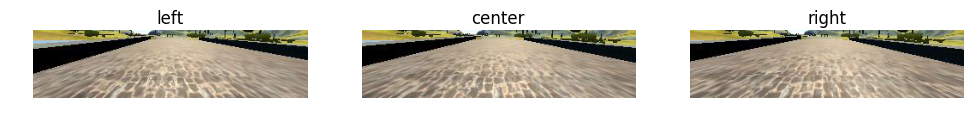

In [9]:
# With cropping
i = 0
for camera in ["left", "center", "right"]:
    image = load_img("data/"+data_frame.iloc[0][camera].strip())
    image = img_to_array(image).astype(np.uint8)
    image = image[55:135, :, :]
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera)
    i += 1

In [18]:
# Remove header
data_frame = data_frame.ix[1:]

# shuffle the data (frac=1 meand 100% of the data)
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [19]:
# 80-20 training validation split
training_split = 0.8

num_rows_training = int(data_frame.shape[0]*training_split)

training_data = data_frame.loc[0:num_rows_training-1]
validation_data = data_frame.loc[num_rows_training:]

# release the main data_frame from memory
data_frame = None

In [102]:
def read_images(img_dataframe):
    imgs = np.empty([len(img_dataframe), 160, 320, 3])
    angles = np.empty([len(img_dataframe)])

    j = 0
    for i, row in img_dataframe.iterrows():
        # Randomly pick left, center, right camera image and adjust steering angle 
        # as necessary
        camera = np.random.choice(["center", "left", "right"])
        
        imgs[j] = imread("data/" + row[camera].strip())
        steering = row["steering"]
        if camera == "left":
            steering += 0.25
        elif camera == "right":
            steering -= 0.25
        angles[j] = steering
        j =+ 1
        
    #for i, path in enumerate(img_paths):
    #    print("data/" + path)
    #    imgs[i] = imread("data/" + path)

    return imgs, angles

In [64]:
def resize(imgs, shape=(32, 16, 3)):
    """
    Resize images to shape.
    """
    height, width, channels = shape
    imgs_resized = np.empty([len(imgs), height, width, channels])
    for i, img in enumerate(imgs):
        imgs_resized[i] = imresize(img, shape)
        #imgs_resized[i] = cv2.resize(img, (16, 32))

    return imgs_resized

In [65]:
def normalize(imgs):
    """
    Normalize images between [-1, 1].
    """
    #return imgs / (255.0 / 2) - 1
    return imgs / 255.0 - 0.5

In [66]:
def augment_brightness(images):
    """
    :param image: Input image
    :return: output image with reduced brightness
    """

    new_imgs = np.empty_like(images)

    for i, image in enumerate(images):
        #rgb = toimage(image)

        # convert to HSV so that its easy to adjust brightness
        hsv = cv2.cvtColor(image.astype("uint8"), cv2.COLOR_RGB2HSV)

        # randomly generate the brightness reduction factor
        # Add a constant so that it prevents the image from being completely dark
        random_bright = .25+np.random.uniform()

        # Apply the brightness reduction to the V channel
        hsv[:,:,2] = hsv[:,:,2]*random_bright

        # convert to RBG again
        new_imgs[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return new_imgs

In [67]:
def preprocess(imgs):
    #imgs_processed = resize(imgs)
    #imgs_processed = rgb2gray(imgs_processed)
    imgs_processed = normalize(imgs)

    return imgs_processed

In [109]:
def gen_batches(data_frame, batch_size):
    """
    Generates random batches of the input data.

    :param imgs: The input images.
    :param angles: The steering angles associated with each image.
    :param batch_size: The size of each minibatch.

    :yield: A tuple (images, angles), where both images and angles have batch_size elements.
    """

    #while True:
    df_batch = data_frame.sample(n=batch_size)
    
    images_raw, angles_raw = read_images(df_batch)
    
    # Show a sample of 3 images
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images_raw[i].astype("uint8"))
        plt.axis("off")
        plt.title(angles_raw[i])
    
    # Augment data by altering brightness of images
    plt.figure()
    augmented_imgs = augment_brightness(images_raw)
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented_imgs[i].astype("uint8"))
        plt.axis('off')
        plt.title(angles_raw[i])
        
    # Pre-process images
    plt.figure()
    batch_imgs, batch_angles = preprocess(augmented_imgs), angles_raw
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(batch_imgs[i].astype("uint8"))
        plt.axis('off')
        plt.title(batch_angles[i])
        
    #batch_imgs, batch_angles = augment(preprocess(batch_imgs_raw), angles_raw)
    #    batch_imgs, batch_angles = augment(batch_imgs_raw, angles_raw)
    #    batch_imgs = preprocess(batch_imgs)

    #    yield batch_imgs, batch_angles

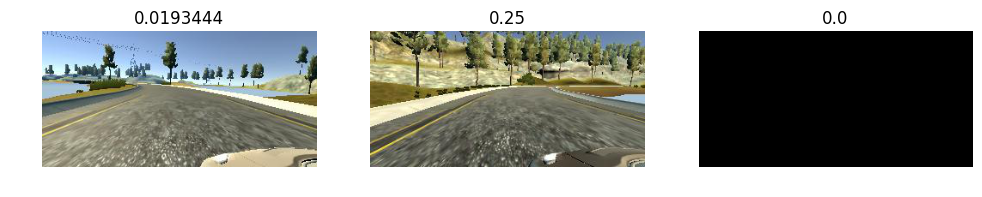

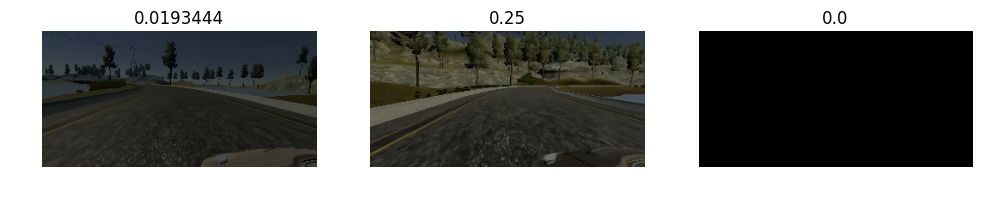

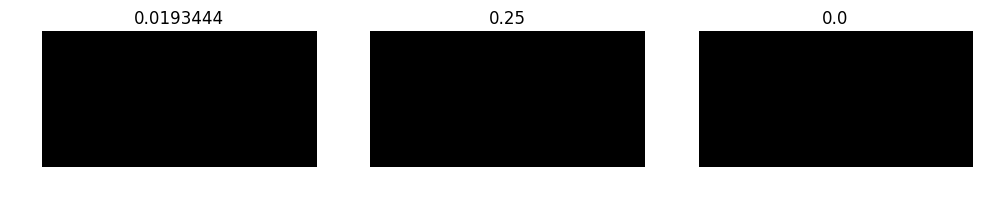

In [112]:
gen_batches(training_data, 128)